### Library Import

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

sys.path.append("..")

from src.sanity import *

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [3]:
from src.load_datasets import load_air_polution_data

dataframe = (
    load_air_polution_data()
    .pipe(format_datetime, col="Date_Time")
    .pipe(set_index, col="Date_Time")
    .pipe(interpolate_column, cols="pollution")
    .pipe(resample_data, freq="H")
)

print(f"dataframe shape {dataframe.shape}")

# dataframe = dataframe.tail(515)

dataframe.head()

format_datetime: DF Shape (43800, 9)
set_index: DF Shape (43800, 8)
interpolate_columns: DF Shape (43800, 8)
resample_Data: DF Shape (43800, 7)
dataframe shape (43800, 7)


,pollution,dewp,temp,press,wnd_spd,snow,rain
Date_Time,,,,,,,
2010-01-02 00:00:00,129.0,-16.0,-4.0,1020.0,1.79,0.0,0.0
2010-01-02 01:00:00,148.0,-15.0,-4.0,1020.0,2.68,0.0,0.0
2010-01-02 02:00:00,159.0,-11.0,-5.0,1021.0,3.57,0.0,0.0
2010-01-02 03:00:00,181.0,-7.0,-5.0,1022.0,5.36,1.0,0.0
2010-01-02 04:00:00,138.0,-7.0,-5.0,1022.0,6.25,2.0,0.0


### test_train_split

train_xy and test_xy size: (43785, 7), (15, 7)

y_train and x_train size (43785,), (43785, 6)
y_test  and x_test  size (15,),  (15, 6)



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

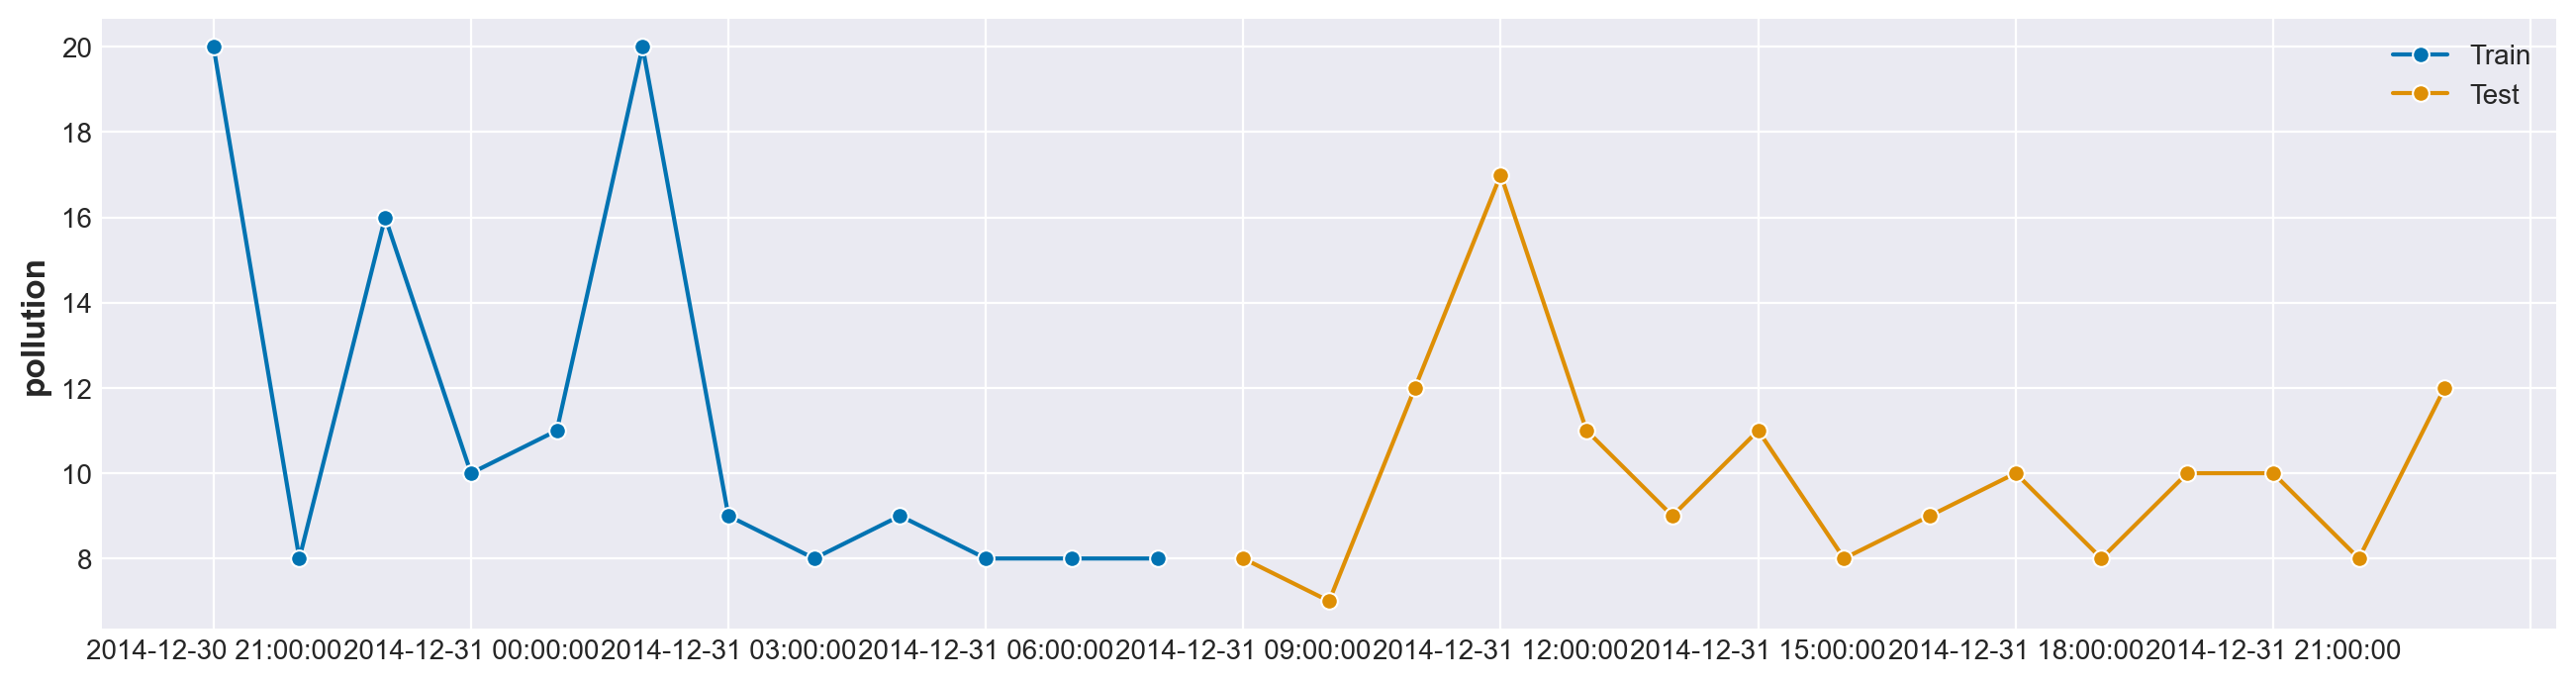

In [4]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

TEST_SIZE = 15
TARGET_COl = "pollution"

train_xy, test_xy = temporal_train_test_split(dataframe, test_size=TEST_SIZE)

print(f"train_xy and test_xy size: {train_xy.shape}, {test_xy.shape}", end="\n\n")

y_train = train_xy[TARGET_COl].copy(deep=True)
x_train = train_xy.drop(columns=[TARGET_COl]).copy(deep=True)

y_test = test_xy[TARGET_COl].copy(deep=True)
x_test = test_xy.drop(columns=[TARGET_COl]).copy(deep=True)

print(f"y_train and x_train size {y_train.shape}, {x_train.shape}")
print(
    f"y_test  and x_test  size {y_test.shape},  {x_test.shape}",
    end="\n\n",
)

plot_series(y_train.tail(12), y_test, labels=["Train", "Test"])

In [5]:
import joblib

trained_model = joblib.load("../results/LassoLars.pkl")


model_n_features_in = trained_model.get_fitted_params()[
    "forecaster__reducer__estimator__n_features_in"
]
model_fname_in = trained_model.get_fitted_params()[
    "forecaster__reducer__estimator__feature_names_in"
]
model_coeff = trained_model.get_fitted_params()["forecaster__reducer__estimator__coef"]
model_intercept = trained_model.get_fitted_params()[
    "forecaster__reducer__estimator__intercept"
]

print(f"model_n_features_in {model_n_features_in}", end="\n\n")
print(f"model_fname_in {model_fname_in}", end="\n\n")
print(f"model_coeff {model_coeff}", end="\n\n")
print(f"model_intercept {model_intercept}", end="\n\n")

model_n_features_in 30

model_fname_in ['pollution_lag_1' 'pollution_lag_2' 'pollution_lag_3' 'pollution_lag_4'
 'pollution_lag_5' 'pollution_lag_6' 'pollution_lag_7' 'pollution_lag_8'
 'pollution_lag_9' 'pollution_lag_10' 'pollution_lag_11'
 'pollution_lag_12' 'pollution_lag_13' 'pollution_lag_14'
 'pollution_lag_15' 'pollution_lag_16' 'pollution_lag_17'
 'pollution_lag_18' 'pollution_lag_19' 'pollution_lag_20'
 'pollution_lag_21' 'pollution_lag_22' 'pollution_lag_23'
 'pollution_lag_24' 'dewp' 'temp' 'press' 'wnd_spd' 'snow' 'rain']

model_coeff [ 1.11393904e+00 -1.71014318e-01 -7.70287654e-03  2.03914177e-02
 -8.84794327e-03 -9.33974218e-03  5.24132849e-03 -1.22259863e-02
  1.02490860e-02 -7.02044390e-03  1.20141616e-02 -6.32008599e-03
  5.41290981e-03 -4.60820188e-03 -6.02772857e-04  5.23747061e-03
  2.47462563e-03  3.32291990e-03  3.01515259e-03 -1.30372703e-03
  1.35349090e-02 -1.57715811e-02  1.66587772e-02 -1.46317786e-02
  2.75414317e-01 -3.27669771e-01  4.06562830e-03 -1.7113

In [6]:
print(x_test.columns)

Index(['dewp', 'temp', 'press', 'wnd_spd', 'snow', 'rain'], dtype='object')


### Forecasting

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

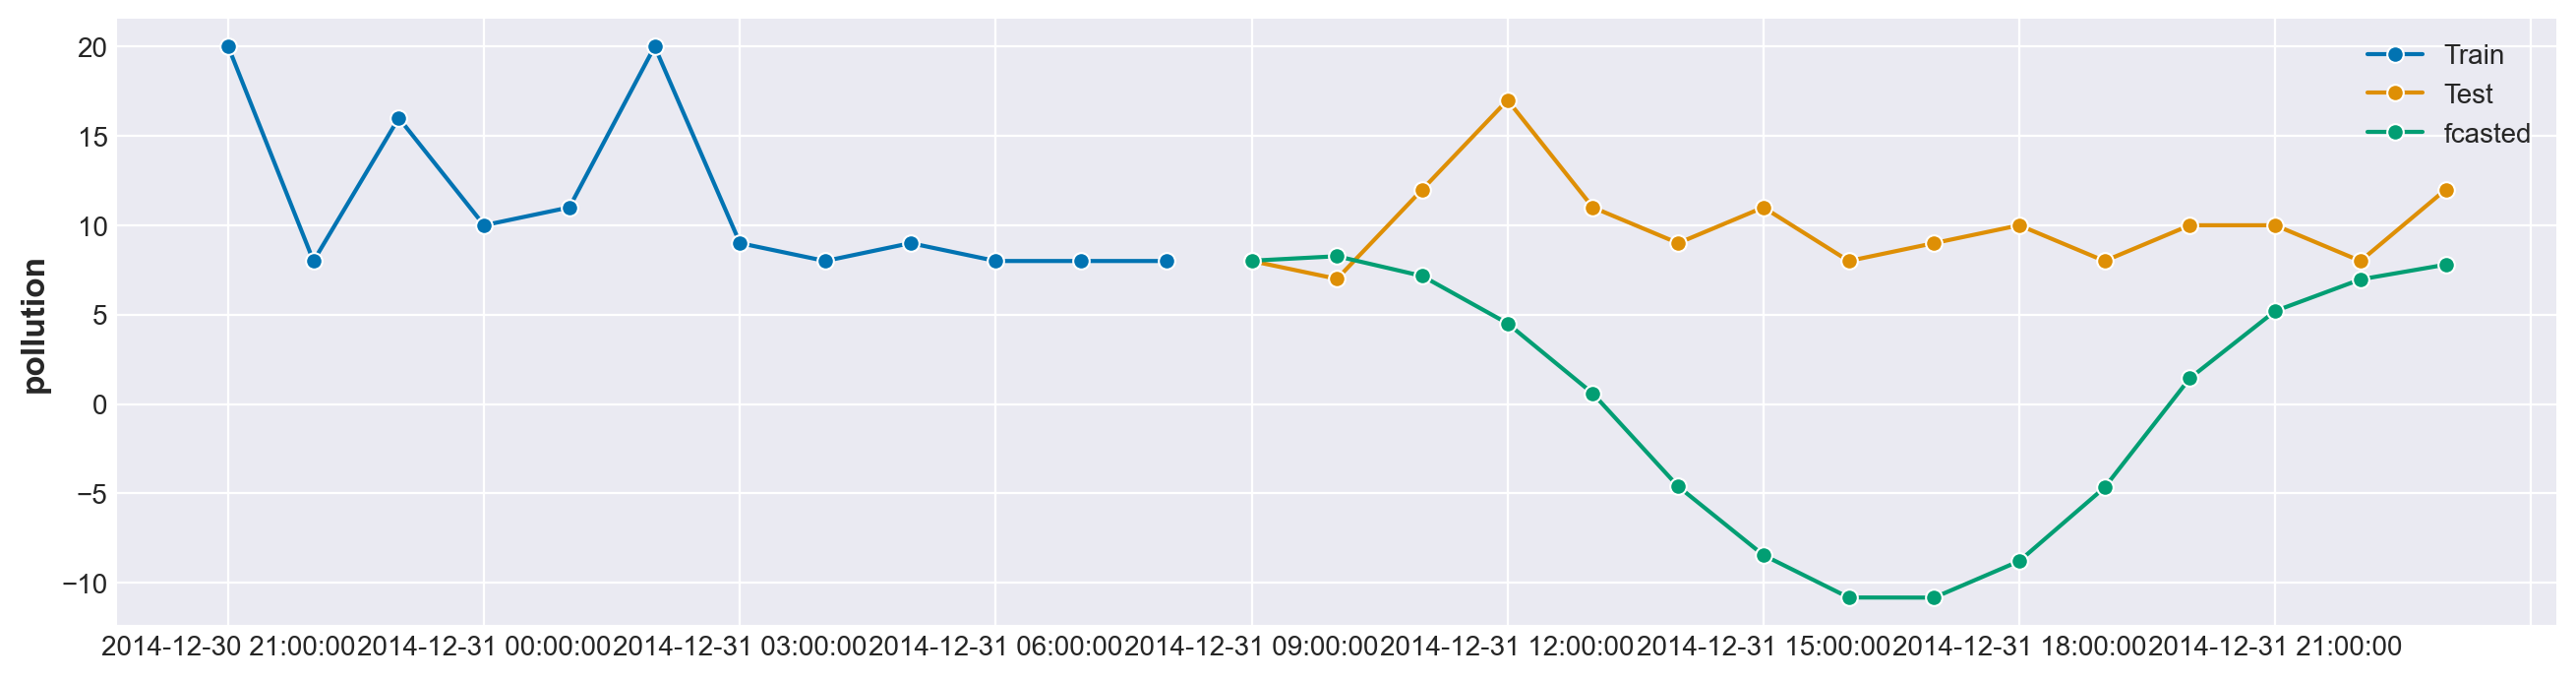

In [7]:
fh = np.arange(1, TEST_SIZE + 1)

y_fcasted = trained_model.predict(fh, X=x_test)

plot_series(y_train.tail(12), y_test, y_fcasted, labels=["Train", "Test", "fcasted"])

In [8]:
print(trained_model.cutoff)

DatetimeIndex(['2014-12-31 08:00:00'], dtype='datetime64[ns]', name='Date_Time', freq='H')


In [9]:
x_test.head()

,dewp,temp,press,wnd_spd,snow,rain
Date_Time,,,,,,
2014-12-31 09:00:00,-22.0,-3.0,1034.0,155.99,0.0,0.0
2014-12-31 10:00:00,-22.0,-2.0,1034.0,163.14,0.0,0.0
2014-12-31 11:00:00,-22.0,-2.0,1034.0,170.29,0.0,0.0
2014-12-31 12:00:00,-22.0,0.0,1033.0,177.44,0.0,0.0
2014-12-31 13:00:00,-27.0,0.0,1032.0,186.38,0.0,0.0


### No Input Graurd in Fitted Model 

In [13]:
x_modified = x_test[["press", "wnd_spd", "snow", "rain", "dewp", "temp"]]
x_modified.head()

KeyError: "None of [Index(['press', 'wnd_spd', 'snow', 'rain', 'dewp', 'temp'], dtype='object')] are in the [columns]"

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

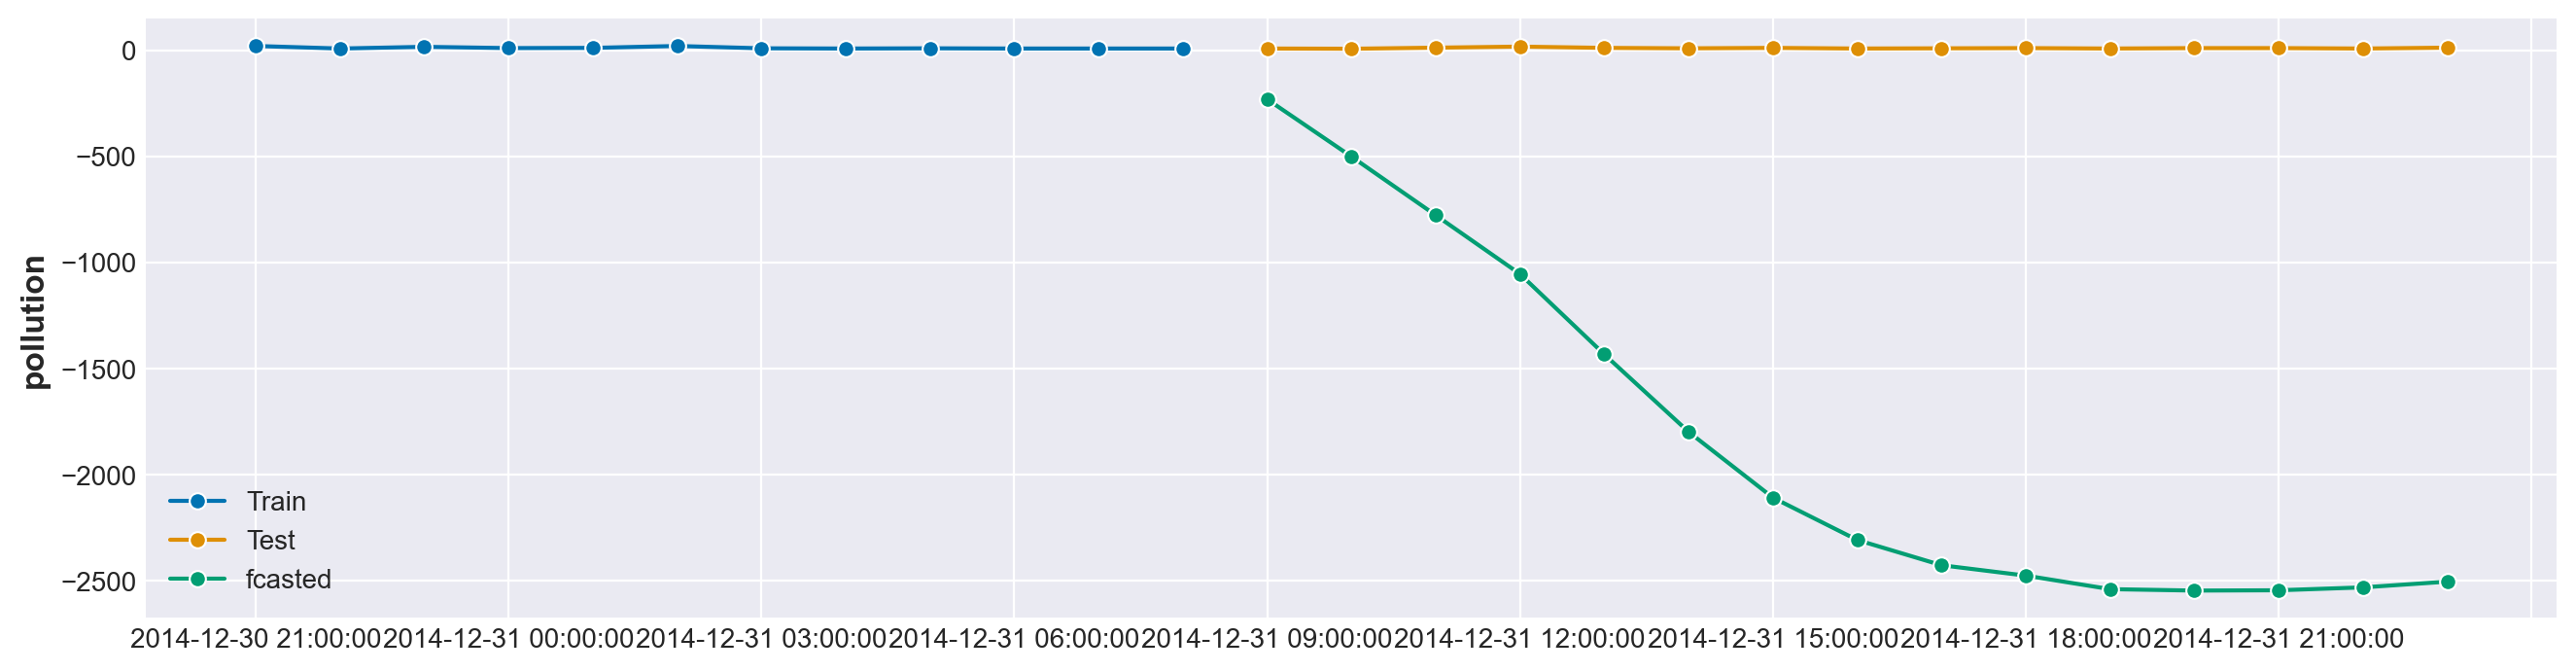

In [22]:
fh = np.arange(1, TEST_SIZE + 1)

y_fcasted = trained_model.predict(fh, X=x_modified)

plot_series(y_train.tail(12), y_test, y_fcasted, labels=["Train", "Test", "fcasted"])